# Edit Images with Stable Difussion and SAM

Segment Anything is a model from Meta that can be used to select portions of images. Combined with Stable Difussion's ability to inpaint specified portions of images, you can use Segment Anything to easily select any part of an image you'd like to alter.

- **Generate mask:** Use Segment Anything to create a dynamic mask.
- **Create new image:** Generate a new image with the masked area inpainted with a fresh prompt.

# Install Libraries


In [ ]:
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!pip install requests
!pip install numpy
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

# Download SAM

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import os
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Set directories for generation images and edit images
base_image_dir = os.path.join("images", "01_inputs")
mask_dir = os.path.join("images", "02_masks")
edit_image_dir = os.path.join("images", "03_edits")

# Point to your downloaded SAM model
sam_model_filepath = "./sam_vit_h_4b8939.pth"

# Initiate SAM model
sam = sam_model_registry["default"](checkpoint=sam_model_filepath)

In [2]:
# Function to display mask using matplotlib
def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# Function to display where we've "clicked"
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

## Generate Mask

Load up one image and generate masks.

In [96]:
# Input image
chosen_image = os.path.join(base_image_dir, "f35.jpg")

# Load chosen image using opencv
image = cv2.imread(chosen_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

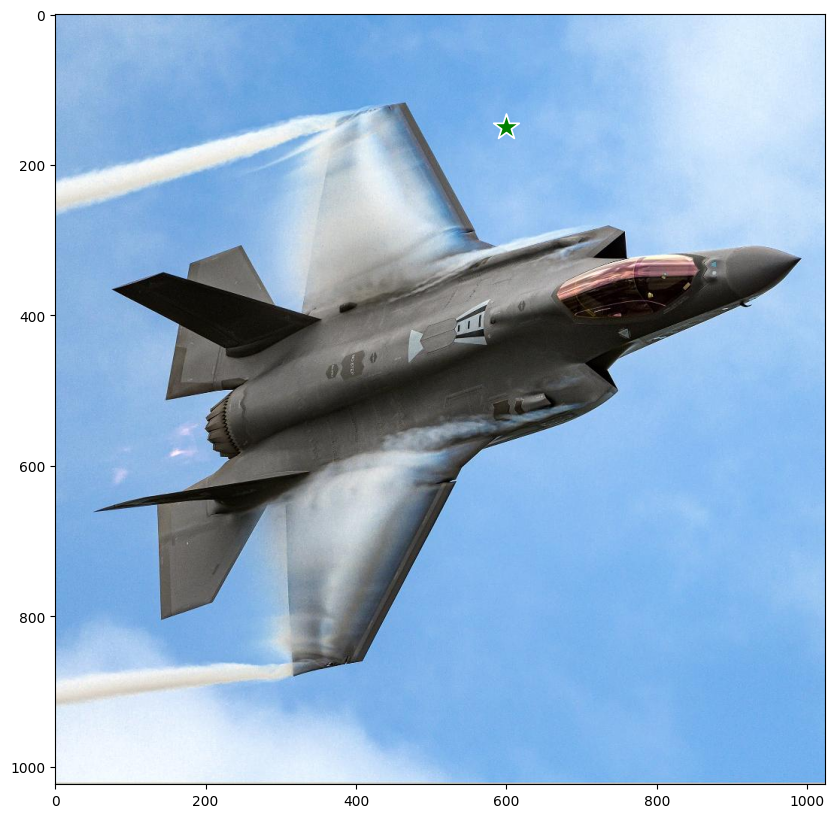

In [122]:
# Set the pixel coordinates for our "click" to assign masks
input_point = np.array([[600, 150]])
input_label = np.array([1])

# Display the point we've clicked on
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

# SAM

In [123]:
# Initiate predictor with Segment Anything model
predictor = SamPredictor(sam)
predictor.set_image(image)

# Use the predictor to gather masks for the point we clicked
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Check the shape - should be three masks of the same dimensions as our image
masks.shape

(3, 1024, 1024)

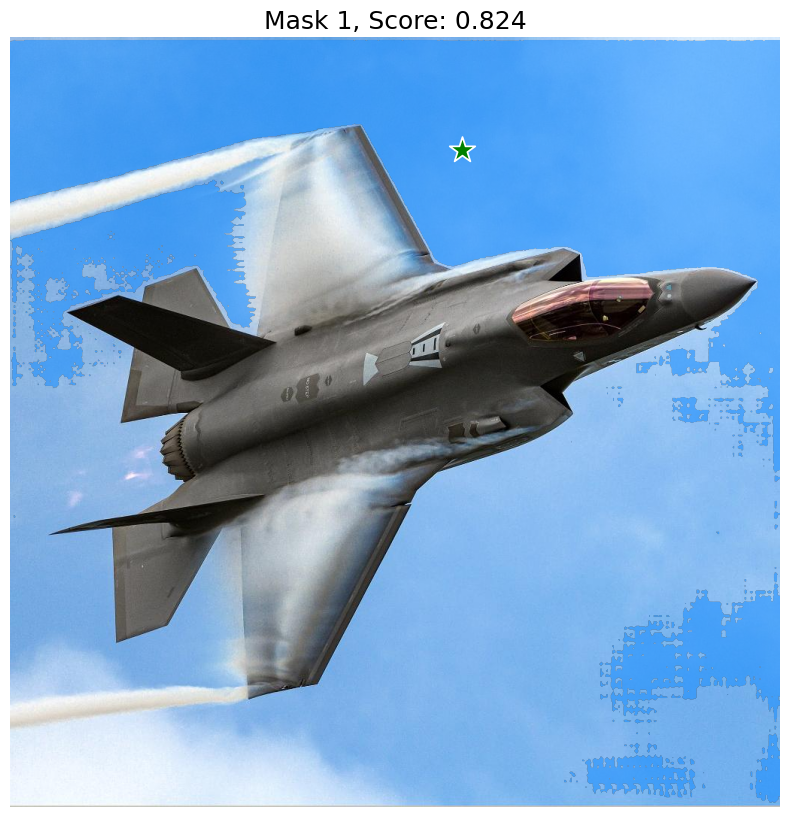

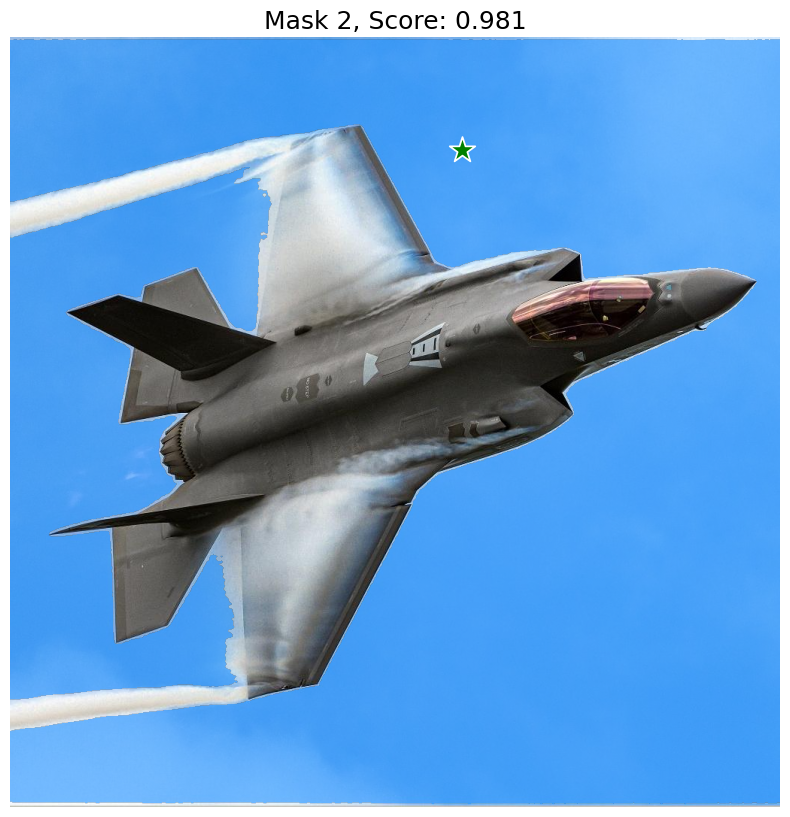

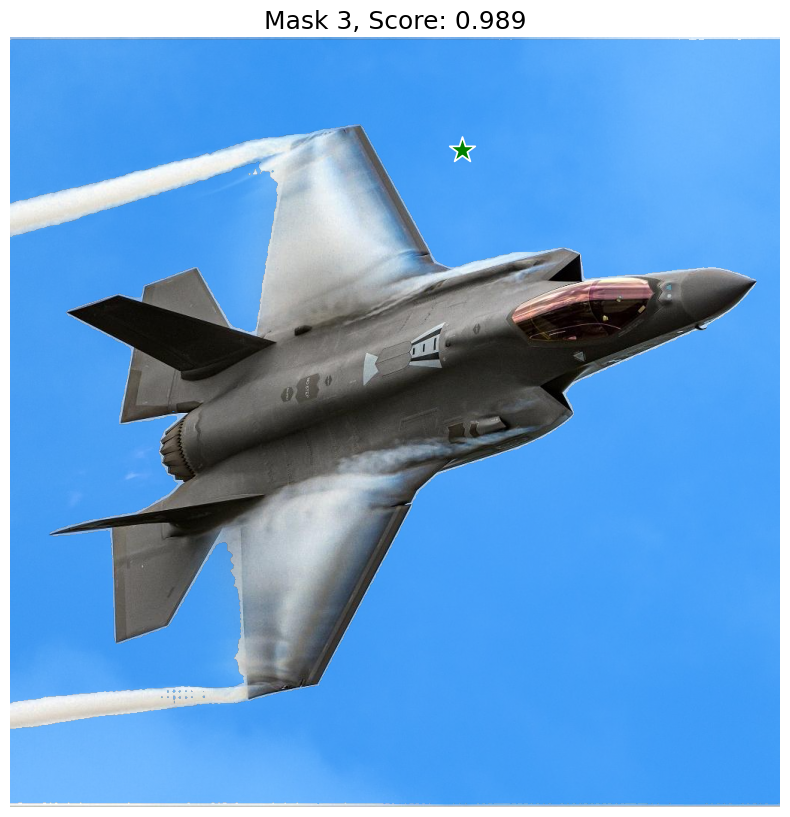

In [124]:
# Display the possible masks we can select along with their confidence
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

In [125]:
# Choose which mask you'd like to use
chosen_mask = masks[2]

# We'll now reverse the mask so that it is clear and everything else is white
chosen_mask = chosen_mask.astype("uint8")
chosen_mask[chosen_mask != 0] = 255
chosen_mask[chosen_mask == 0] = 1
chosen_mask[chosen_mask == 255] = 0
chosen_mask[chosen_mask == 1] = 255

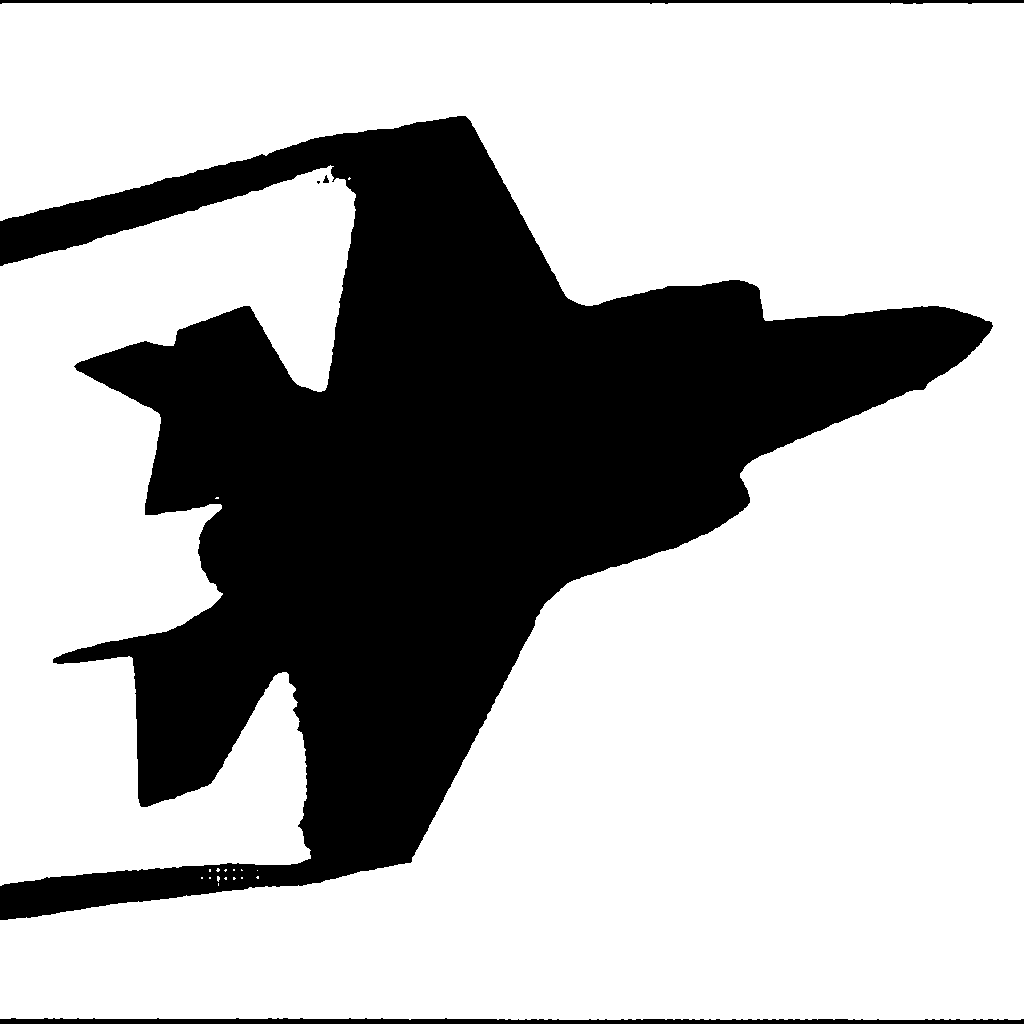

In [126]:
# create a base blank mask
width = 1024
height = 1024
mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))  # create an opaque image mask

# Convert mask back to pixels to add our mask replacing the third dimension
pix = np.array(mask)
pix[:, :, 3] = chosen_mask

# Convert pixels back to an RGBA image and display
new_mask = Image.fromarray(pix, "RGBA")
new_mask

In [128]:
# We'll save this mask for re-use for our edit
new_mask.save(os.path.join(mask_dir, "new_mask.png"))

### Mask for Stable Difussion

In [129]:
# Assuming img is your input image with an alpha channel
img = Image.open(os.path.join(mask_dir, "new_mask.png"))

# Convert transparent area to white
img = img.convert("RGBA")
data = img.getdata()

new_data = []
for item in data:
    # Set transparent area (alpha channel) to 255 (fully opaque) and RGB to white
    if item[3] == 0:  # Check if the alpha channel is 0 (transparent)
        new_data.append((255, 255, 255, 255))
    else:
        new_data.append(item)

img.putdata(new_data)

# Save the result or display it
img.save(os.path.join(mask_dir, "new_mask.png"))

# Create New Image with Stable Difussion

In [61]:
from huggingface_hub import notebook_login

notebook_login()

In [130]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [131]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

vae/diffusion_pytorch_model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

In [132]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

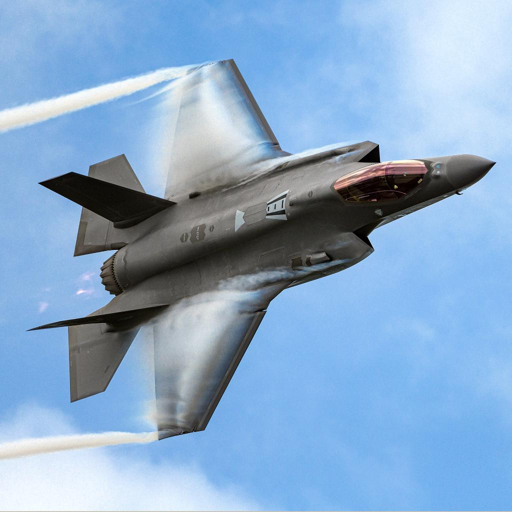

In [136]:
image = PIL.Image.open(chosen_image).convert("RGB").resize((512, 512))

image

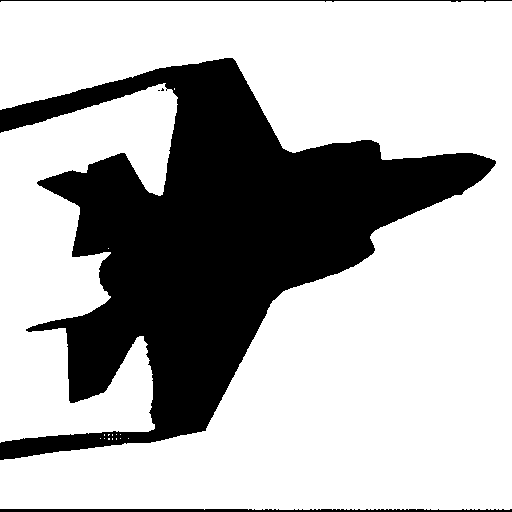

In [133]:
mask = PIL.Image.open(os.path.join(mask_dir, "new_mask.png")).convert('1').resize((512, 512))
mask

In [134]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [144]:
prompt = "Generate an awe-inspiring scene featuring a futuristic cityscape at sunset, with towering skyscrapers casting long shadows. In the foreground, place a sleek and powerful jet fighter, its metallic surface reflecting the warm hues of the setting sun."

guidance_scale=7.5
num_samples = 3

generator = torch.Generator(device="cuda").manual_seed(0)
images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [146]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

image_grid(images, 1, num_samples + 1)

AssertionError: 

# Save Generated Images

In [147]:
for i, img in enumerate(images[1:]):
    print(img)

    img.save(os.path.join(edit_image_dir, "generated_{}.png".format(i+1)))

<PIL.Image.Image image mode=RGB size=512x512 at 0x241A1F3E1D0>
<PIL.Image.Image image mode=RGB size=512x512 at 0x241A1C201C0>
<PIL.Image.Image image mode=RGB size=512x512 at 0x2422AFB9810>
<PIL.Image.Image image mode=RGB size=512x512 at 0x2422AFB99C0>
